In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

from sklearn.datasets import make_circles

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Datos artificiales

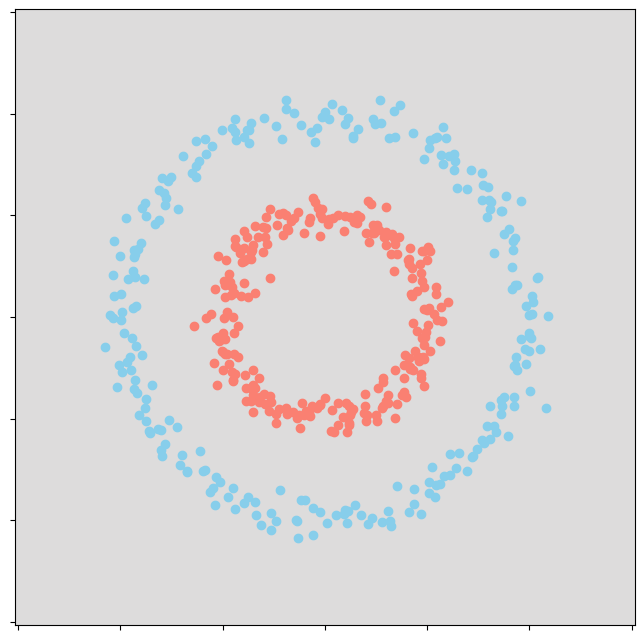

In [3]:
# Creamos nuestros datos artificiales, donde buscaremos clasificar 
# dos anillos concéntricos de datos. 
X, Y = make_circles(n_samples=500, factor=0.5, noise=0.05)

# Resolución del mapa de predicción.
res = 100 

# Coordendadas del mapa de predicción.
_x0 = np.linspace(-1.5, 1.5, res)
_x1 = np.linspace(-1.5, 1.5, res)

# Input con cada combo de coordenadas del mapa de predicción.
_pX = np.array(np.meshgrid(_x0, _x1)).T.reshape(-1, 2)

# Objeto vacio a 0.5 del mapa de predicción.
_pY = np.zeros((res, res)) + 0.5

# Visualización del mapa de predicción.
plt.figure(figsize=(8, 8))
plt.pcolormesh(_x0, _x1, _pY, cmap="coolwarm", vmin=0, vmax=1)

# Visualización de la nube de datos.
plt.scatter(X[Y == 0,0], X[Y == 0,1], c="skyblue")
plt.scatter(X[Y == 1,0], X[Y == 1,1], c="salmon")

plt.tick_params(labelbottom=False, labelleft=False)

## Tensorflow

In [4]:
# Librerias para tensorflow
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from matplotlib import animation
from IPython.core.display import display, HTML

2023-04-18 16:26:36.824683: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
non-resource variables are not supported in the long term


In [5]:
# Definimos los puntos de entrada de la red, para la matriz X e Y.
iX = tf.placeholder('float', shape=[None, X.shape[1]])
iY = tf.placeholder('float', shape=[None]) # vector de salida Y

lr = 0.01           # learning rate
nn = [2, 16, 8, 1]  # número de neuronas por capa.

# En cada capa se produce una suma ponderada que es equivalente a una multiplicación matricial + el parametro de bias y luego lo pasamos por una 
# función de activación (RELU)
# y = w1x1 + w2x2 + b

# Primero se definen los parámetros que van a ser optimizados dentro de nuestra red --> variable
# vamos a indicar que sus valores van a ser inicializados aleatoriamente y que tendrá las siguientes dimensiones
# Capa 1
W1 = tf.Variable(tf.random_normal([nn[0], nn[1]]), name='Weights_1')
b1 = tf.Variable(tf.random_normal([nn[1]]), name='bias_1')

# indicamos que las operaciones de la capa 1 van a ser la de multiplicar nuestro input "ix" con la matriz de parámetros
# "w1", sumar el parámetro de bias y pasarlo todo por la función de activación "relu"
l1 = tf.nn.relu(tf.add(tf.matmul(iX, W1), b1))

# Capa 2
W2 = tf.Variable(tf.random_normal([nn[1], nn[2]]), name='Weights_2')
b2 = tf.Variable(tf.random_normal([nn[2]]), name='bias_2')

l2 = tf.nn.relu(tf.add(tf.matmul(l1, W2), b2))

# Capa 3
W3 = tf.Variable(tf.random_normal([nn[2], nn[3]]), name='Weights_3')
b3 = tf.Variable(tf.random_normal([nn[3]]), name='bias_3')

# Vector de predicciones de Y.
# Como es la última capa de salida, le ponemos la funcion sigmoide y no la relu para que los valores del
# output queden acotados entre 0 y 1
pY = tf.nn.sigmoid(tf.add(tf.matmul(l2, W3), b3))[:, 0]

# HASTA AQUI DEFINIMOS EL GRAFO DE OPERACIONES

# Evaluación de las predicciones.
# tomamos la función de costo, ej: error cuadrárico medio y comparar nuestras predicciones con el vector de salida original
# introducido por el placeholder e "y"
# con esto evaluamos los resultados y utilizamos el error para optimizar a toda la red (minimizar el error)
loss = tf.losses.mean_squared_error(pY, iY)

# Definimos al optimizador de la red, para que minimice el error.
# utilizamos el descenso del gradiente para minimizar el costo
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.05).minimize(loss)

# HASTA AQUI TENEMOS PLANTEADAS TODAS LAS OPERACIONES Y SOLO RESTA INTRODUCIR LOS DATOS Y DEJAR QUE TENSORFLOW INICIE EL PROCESO
# DE AUTODIFERENCIACIÓN Y ENTRENAMIENTO

n_steps = 1000 # Número de ciclos de entrenamiento.

iPY = [] # Aquí guardaremos la evolución de las predicción, para la animación.

# iniciamos una sesión
with tf.Session() as sess:
  
  # Inicializamos todos los parámetros de la red, las matrices W y b.
  sess.run(tf.global_variables_initializer())
    
  # Iteramos n pases de entrenamiento.
  for step in range(n_steps):
  
    # Evaluamos al optimizador, a la función de coste y al tensor de salida pY. 
    # La evaluación del optimizer producirá el entrenamiento de la red.
    # con feed dict pasamos la matriz de entrada y el vector de salida
    # tensores: optimizer, loss, Py
    # devuelve el resultado del optimizador (lo vamos a descartar), el rtdo de la funcion de costo y el vector de predicciones
    # tras una iteración de entrenamiento
    _, _loss, _pY = sess.run([optimizer, loss, pY], feed_dict={ iX : X, iY : Y })
    
    # Cada 25 iteraciones, imprimimos métricas.
    if step % 25 == 0: 
      
      # Cálculo del accuracy.
      acc = np.mean(np.round(_pY) == Y)
      
      # Impresión de métricas.
      print('Step', step, '/', n_steps, '- Loss = ', _loss, '- Acc =', acc)
      
      # Obtenemos predicciones para cada punto de nuestro mapa de predicción _pX.
      _pY = sess.run(pY, feed_dict={ iX : _pX }).reshape((res, res))

      # Y lo guardamos para visualizar la animación.
      iPY.append(_pY)

Step 0 / 1000 - Loss =  0.5 - Acc = 0.5


2023-04-18 16:26:39.322875: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-18 16:26:39.325052: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled


Step 25 / 1000 - Loss =  0.5 - Acc = 0.5
Step 50 / 1000 - Loss =  0.5 - Acc = 0.5
Step 75 / 1000 - Loss =  0.5 - Acc = 0.5
Step 100 / 1000 - Loss =  0.5 - Acc = 0.5
Step 125 / 1000 - Loss =  0.5 - Acc = 0.5
Step 150 / 1000 - Loss =  0.5 - Acc = 0.5
Step 175 / 1000 - Loss =  0.5 - Acc = 0.5
Step 200 / 1000 - Loss =  0.5 - Acc = 0.5
Step 225 / 1000 - Loss =  0.5 - Acc = 0.5
Step 250 / 1000 - Loss =  0.5 - Acc = 0.5
Step 275 / 1000 - Loss =  0.5 - Acc = 0.5
Step 300 / 1000 - Loss =  0.5 - Acc = 0.5
Step 325 / 1000 - Loss =  0.5 - Acc = 0.5
Step 350 / 1000 - Loss =  0.5 - Acc = 0.5
Step 375 / 1000 - Loss =  0.5 - Acc = 0.5
Step 400 / 1000 - Loss =  0.5 - Acc = 0.5
Step 425 / 1000 - Loss =  0.5 - Acc = 0.5
Step 450 / 1000 - Loss =  0.5 - Acc = 0.5
Step 475 / 1000 - Loss =  0.5 - Acc = 0.5
Step 500 / 1000 - Loss =  0.5 - Acc = 0.5
Step 525 / 1000 - Loss =  0.5 - Acc = 0.5
Step 550 / 1000 - Loss =  0.5 - Acc = 0.5
Step 575 / 1000 - Loss =  0.5 - Acc = 0.5
Step 600 / 1000 - Loss =  0.5 - Acc =

In [6]:
# La ventaja de trabajar con Tensorflow es que si quisieramos modificar algún aspecto de la arquitectura de la red, solo tendriamos
# que hacer cambios en la primera parte del código y el resto del proceso de atutodiferenciación y entrenamiento se computará automáticamentes

--- Generando animación ---


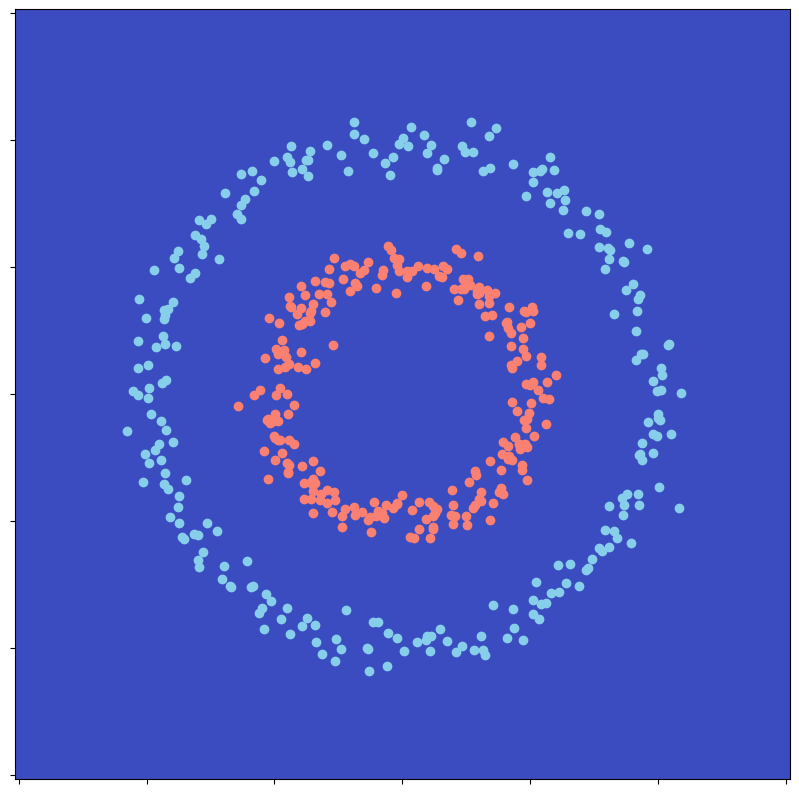

In [7]:
# ----- CÓDIGO ANIMACIÓN ----- #

ims = []

fig = plt.figure(figsize=(10, 10))

print("--- Generando animación ---")

for fr in range(len(iPY)):
  
  im = plt.pcolormesh(_x0, _x1, iPY[fr], cmap="coolwarm", animated=True)

  # Visualización de la nube de datos.
  plt.scatter(X[Y == 0,0], X[Y == 0,1], c="skyblue")
  plt.scatter(X[Y == 1,0], X[Y == 1,1], c="salmon")

  # plt.title("Resultado Clasificación")
  plt.tick_params(labelbottom=False, labelleft=False)

  ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)

HTML(ani.to_html5_video())

## Keras
---
VER EN LA NB 2

In [ ]:
# Keras plantea una interfaz sencilla a nivel de capa de todas las funcionalidades que nos aporta tensorflow
# combinamos diferentes tipos de capas para conformar la red neuronal

## Sklearn

In [9]:
# Sklearn
import sklearn as sk
import sklearn.neural_network

from IPython.core.display import display, HTML

In [10]:
# Pasamos ahora a tratar las redes neuronales desde un punto de vista de modelo
# Miramos a la red como un todo.
# La arquitectura ya esta predefinida y lo controlamos de manera limitada ajustando algunos hiperparámetros

lr = 0.01           # learning rate
nn = [2, 16, 8, 1]  # número de neuronas por capa.

# Creamos el objeto del modelo de red neuronal multicapa.
# utilizamos el regresor para seguir obteniendo la probabilidad de pertenencia a una de las clases
clf = sk.neural_network.MLPRegressor(solver='sgd', # tipo de optimizador
                                     learning_rate_init=lr, # learning rate inicial
                                     hidden_layer_sizes=tuple(nn[1:]), # num de neuronas para cada capa oculta
                                     verbose=True,
                                     n_iter_no_change=1000, # num de iteracciones a entrenar
                                     batch_size = 64)


# Y lo entrenamos con nuestro datos.
clf.fit(X, Y)

Iteration 1, loss = 0.51308977
Iteration 2, loss = 0.25581452
Iteration 3, loss = 0.13993656
Iteration 4, loss = 0.12776367
Iteration 5, loss = 0.13174878
Iteration 6, loss = 0.12905167
Iteration 7, loss = 0.12572784
Iteration 8, loss = 0.12503710
Iteration 9, loss = 0.12531696
Iteration 10, loss = 0.12523190
Iteration 11, loss = 0.12506097
Iteration 12, loss = 0.12504927
Iteration 13, loss = 0.12506933
Iteration 14, loss = 0.12507422
Iteration 15, loss = 0.12510334
Iteration 16, loss = 0.12507700
Iteration 17, loss = 0.12501051
Iteration 18, loss = 0.12506450
Iteration 19, loss = 0.12516573
Iteration 20, loss = 0.12508291
Iteration 21, loss = 0.12506923
Iteration 22, loss = 0.12513119
Iteration 23, loss = 0.12507602
Iteration 24, loss = 0.12503154
Iteration 25, loss = 0.12508156
Iteration 26, loss = 0.12510779
Iteration 27, loss = 0.12503068
Iteration 28, loss = 0.12511663
Iteration 29, loss = 0.12505147
Iteration 30, loss = 0.12511651
Iteration 31, loss = 0.12507340
Iteration 32, los

MLPRegressor(batch_size=64, hidden_layer_sizes=(16, 8, 1),
             learning_rate_init=0.01, n_iter_no_change=1000, solver='sgd',
             verbose=True)

In [ ]:
# Si quisieramos hacer predicciones
# model.predict(Xp)